# Benchmark Comparisons

Compare my implementations and Spinning Up versions of RL algos on MuJoCo Gym tasks.
https://spinningup.openai.com/en/latest/spinningup/bench.html

In [412]:
from collections import defaultdict
import glob, os, sys
import pandas as pd
import plotnine as pn
DATA_DIR = '/Users/kurtsmith/research/spinningup/data'

In [413]:
task_list = ['hopper_v3', 'halfcheetah_v3', 'ant_v3', 'walker2d_v3', 'swimmer_v3']
method_list = ['su_ppo', 'ppo', 'su_ddpg', 'ddpg', 'su_td3', 'td3', 'su_sac', 'sac']
# return_col = defaultdict(lambda: 'AverageEpRet')
# return_col['su_ddpg']
output_paths = {}
full_data = {}
for task in task_list:
    output_paths[task] = {}
    full_data[task] = {}
    for method in method_list:
        my_path = f'{DATA_DIR}/{task}/{method}'
        if os.path.exists(my_path):
            output_paths[task][method] = os.listdir(my_path)

In [414]:
for task in task_list:
    for method in output_paths[task].keys():
        results = []
        for run in output_paths[task][method]:
            progress = pd.read_table(f'{DATA_DIR}/{task}/{method}/{run}/progress.txt')
            progress['Minutes'] =  progress['Time']/60.
            progress['Hours'] =  progress['Time']/60./60.
            progress['task'] = task
            progress['method'] = method
            progress['run'] = run
            results.append(progress)
        if len(results)>0:
            full_data[task][method] = pd.concat(results)

In [415]:
def plot_run_returns(df, col=None, task=None, method=None, line=True, points=False):
    if col is None:
        col = 'AverageTestEpRet' if 'AverageTestEpRet' in df.columns else 'AverageEpRet'
    plot = pn.ggplot(df, pn.aes(x='TotalEnvInteracts', y=col))
    if line:
        plot += pn.geom_line(pn.aes(color='run'))
    if points:
        plot += pn.geom_point(pn.aes(color='run'))
    if task is not None:
        plot += pn.labels.ggtitle(f'{task} : {method}')        
    return plot

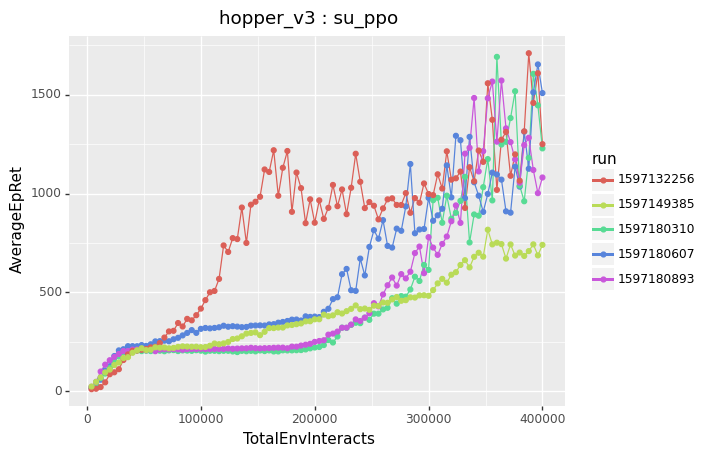

<ggplot: (8762421542583)>

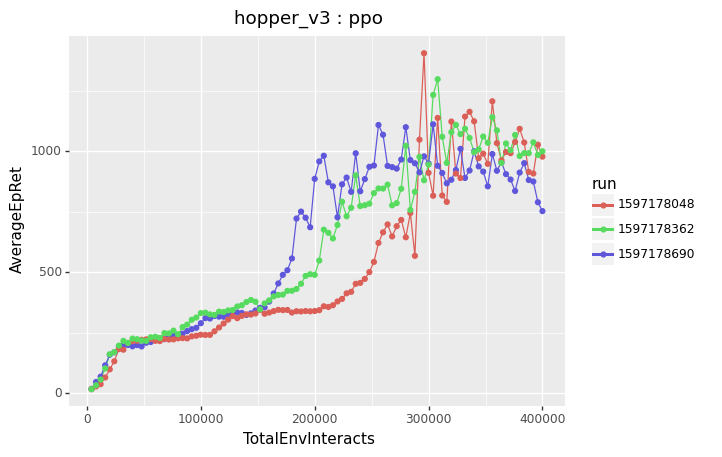

<ggplot: (8762421542583)>

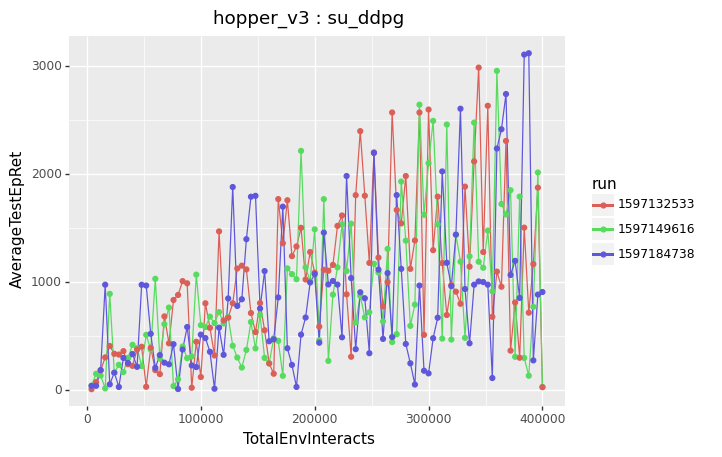

<ggplot: (8762421542583)>

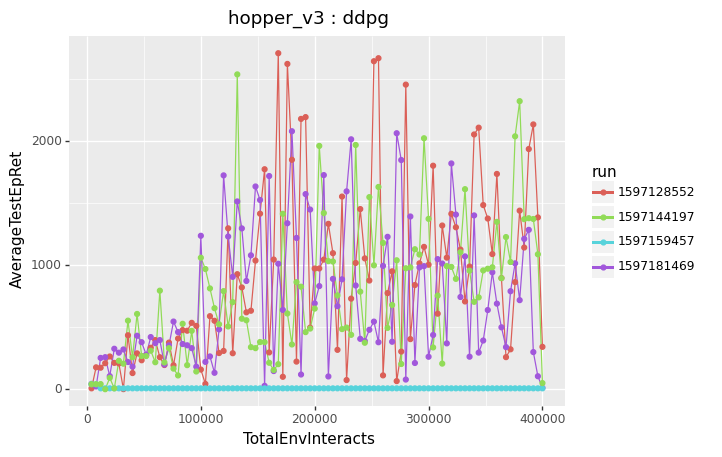

<ggplot: (8762421542583)>

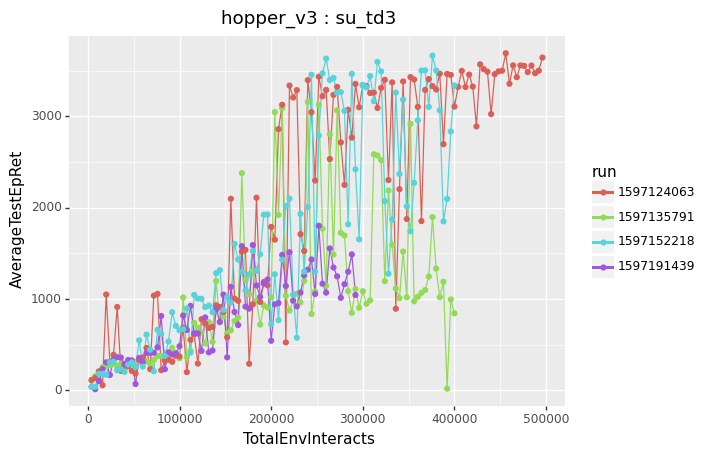

<ggplot: (8762421542583)>

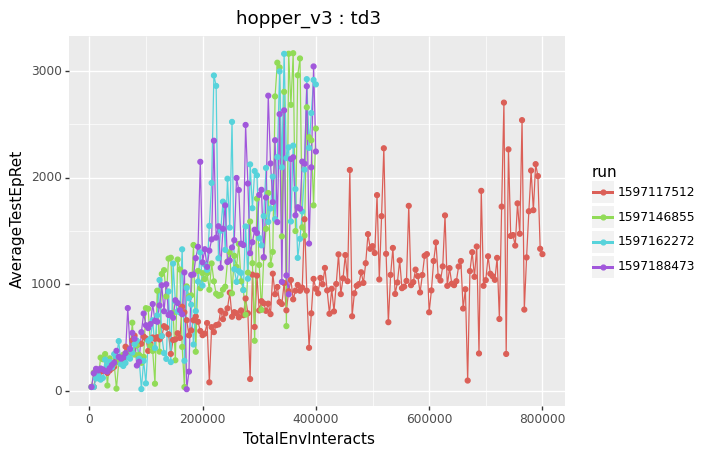

<ggplot: (-9223363274466356718)>

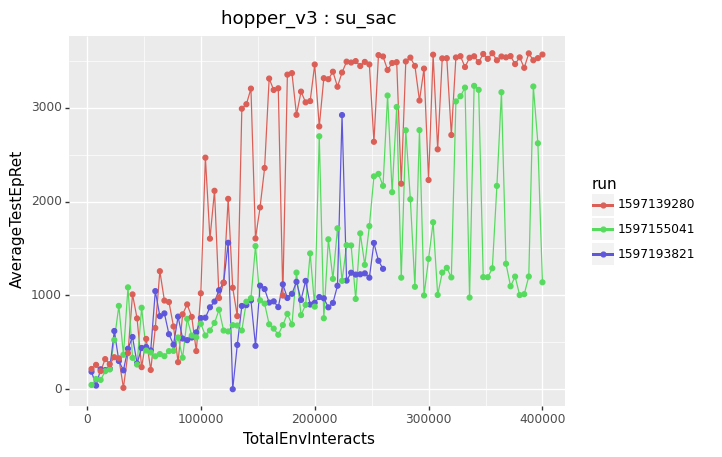

<ggplot: (8762388004963)>

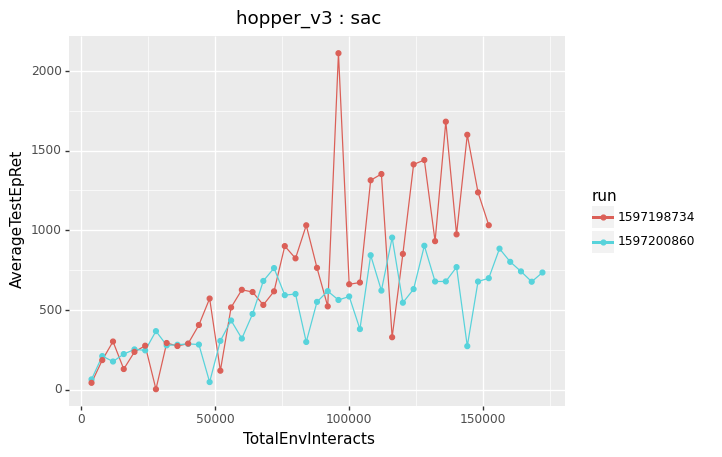

<ggplot: (8762388419115)>

In [416]:
task = 'hopper_v3'
for method in full_data[task].keys():
    display(plot_run_returns(full_data[task][method], task=task, method=method, points=True))
# display(plot_run_returns(full_data[task]['td3']))

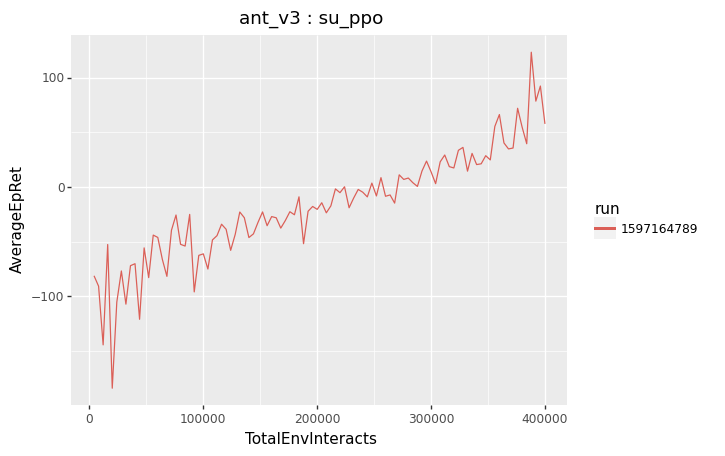

<ggplot: (8762388370429)>

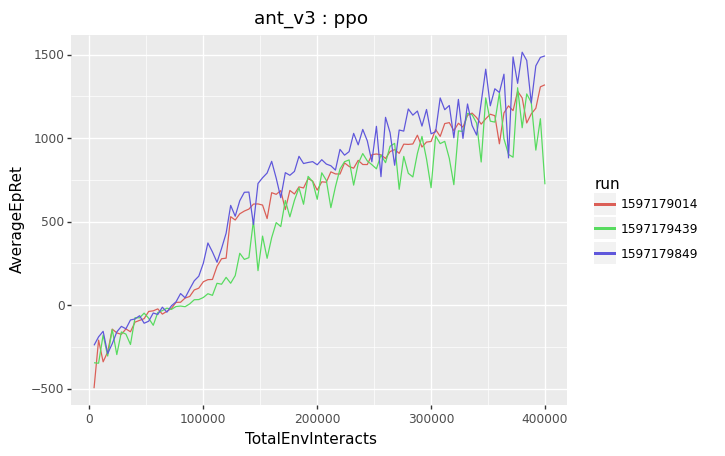

<ggplot: (8762388370429)>

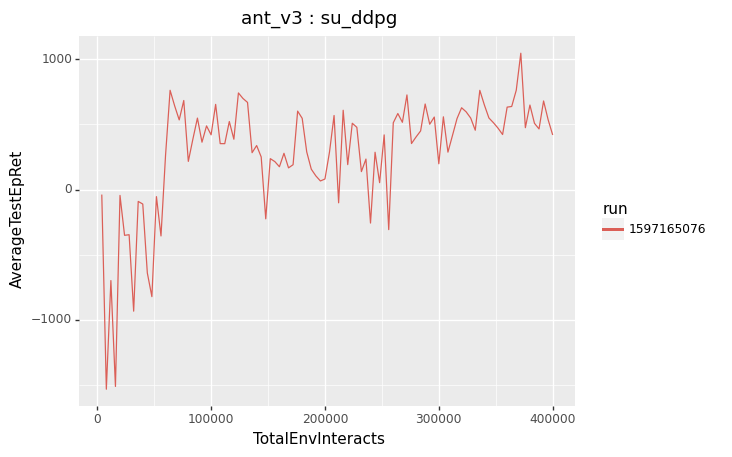

<ggplot: (8762388426991)>

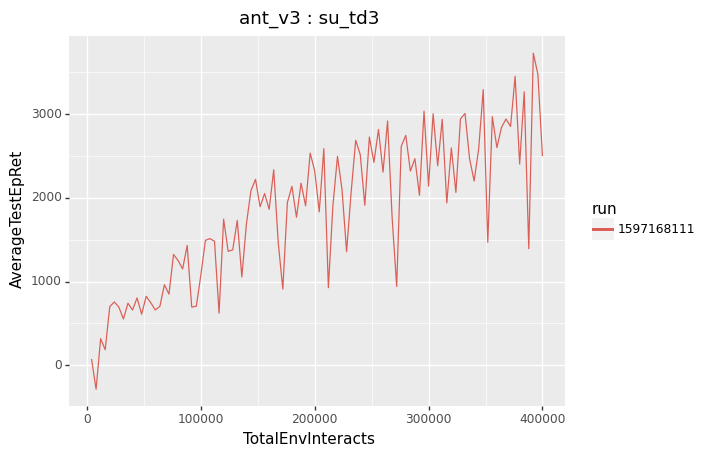

<ggplot: (8762388426991)>

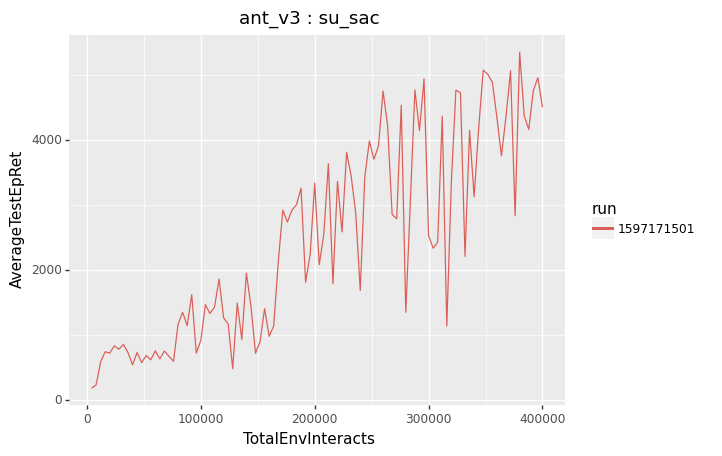

<ggplot: (8762388426991)>

In [417]:
task = 'ant_v3'
for method in full_data[task].keys():
    display(plot_run_returns(full_data[task][method], task=task, method=method))
# display(plot_run_returns(full_data[task]['td3']))

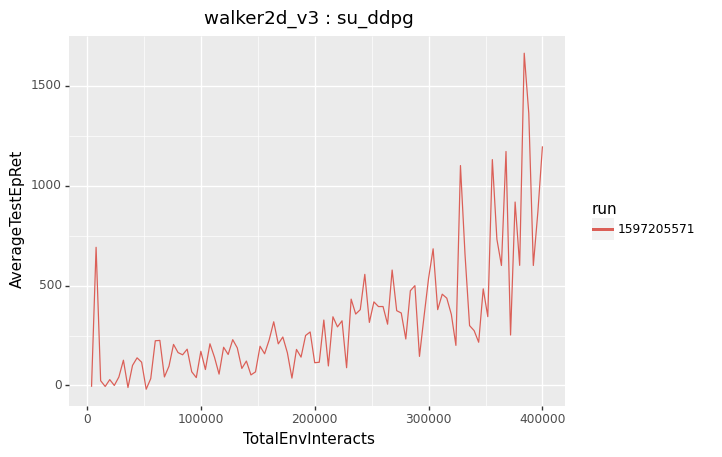

<ggplot: (-9223363274466405383)>

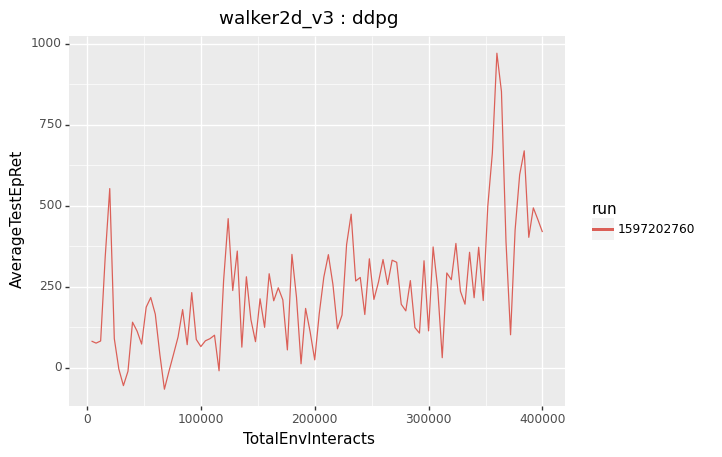

<ggplot: (-9223363274508607330)>

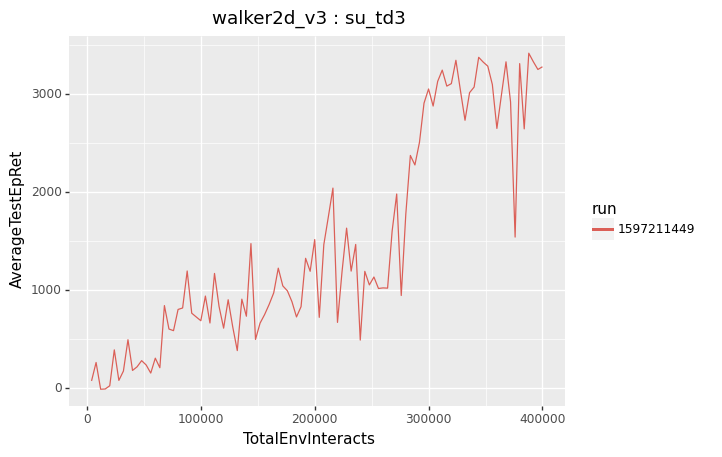

<ggplot: (-9223363274508607330)>

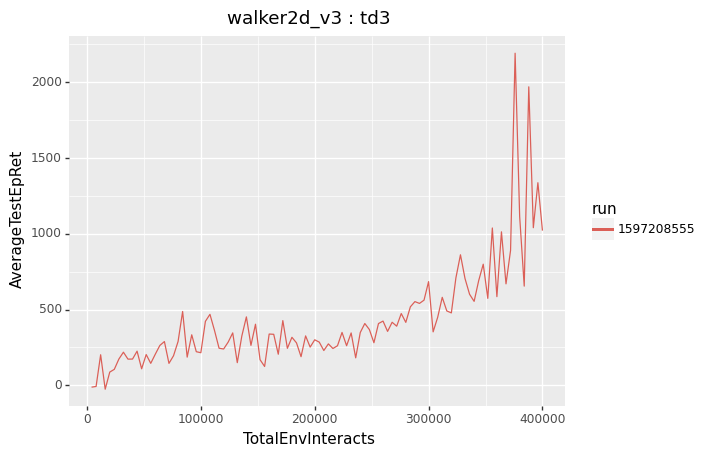

<ggplot: (-9223363274508607330)>

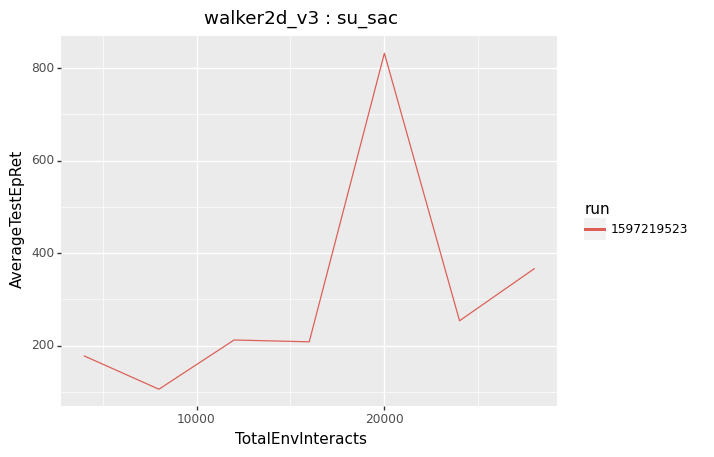

<ggplot: (-9223363274508607330)>

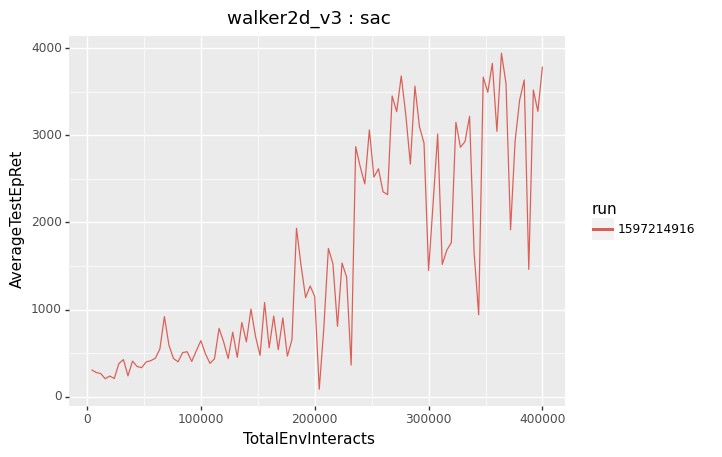

<ggplot: (-9223363274508607330)>

In [418]:
task = 'walker2d_v3'
for method in full_data[task].keys():
    display(plot_run_returns(full_data[task][method], task=task, method=method))
# display(plot_run_returns(full_data[task]['td3']))

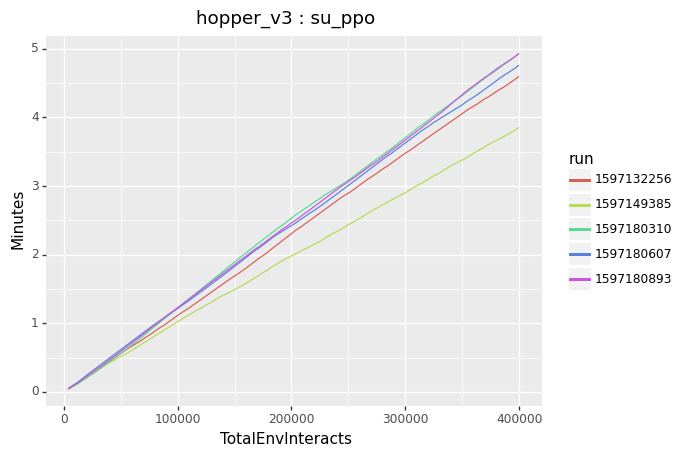

<ggplot: (-9223363274466405411)>

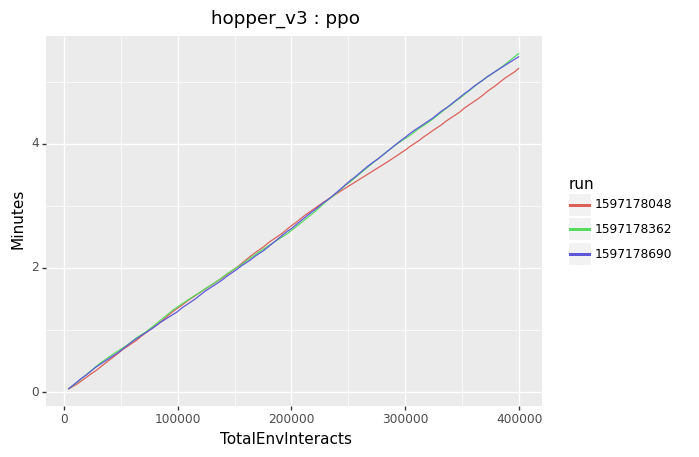

<ggplot: (-9223363274466405411)>

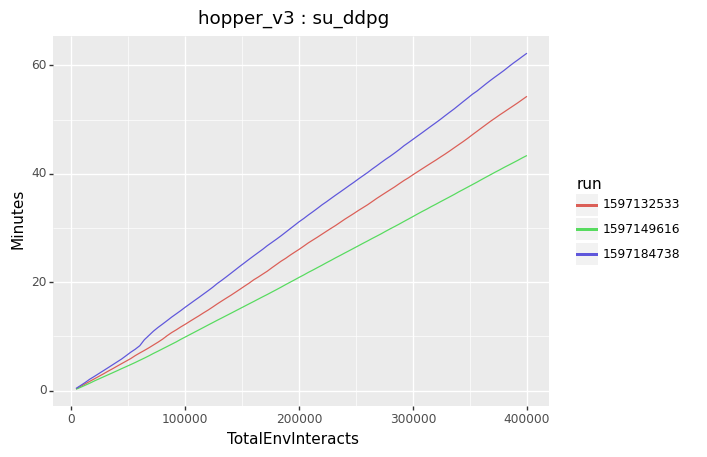

<ggplot: (-9223363274466405411)>

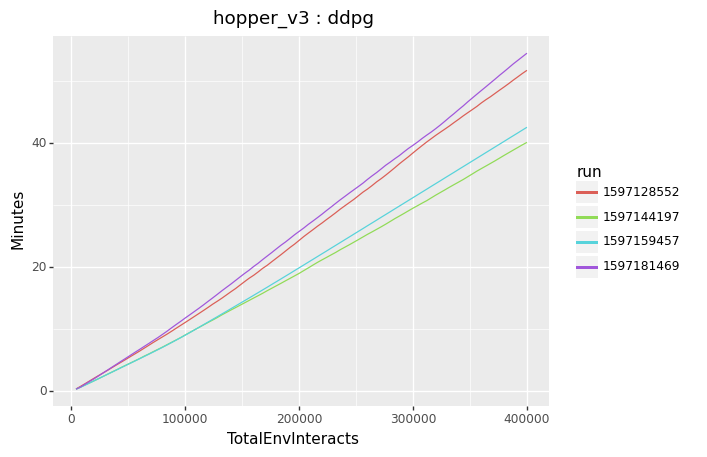

<ggplot: (-9223363274466405411)>

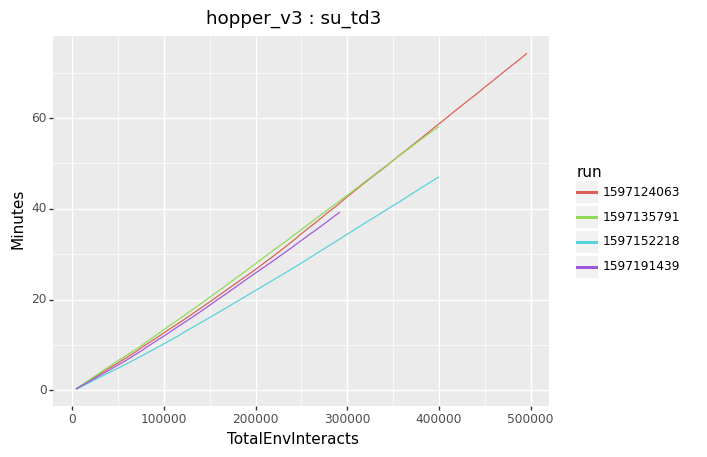

<ggplot: (-9223363274466405411)>

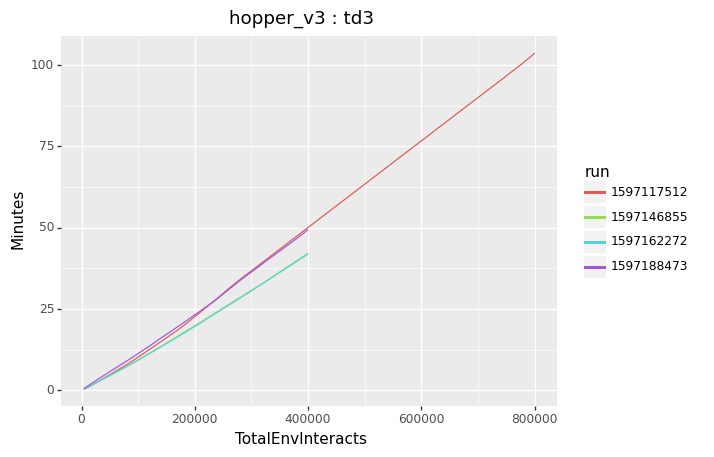

<ggplot: (-9223363274466559677)>

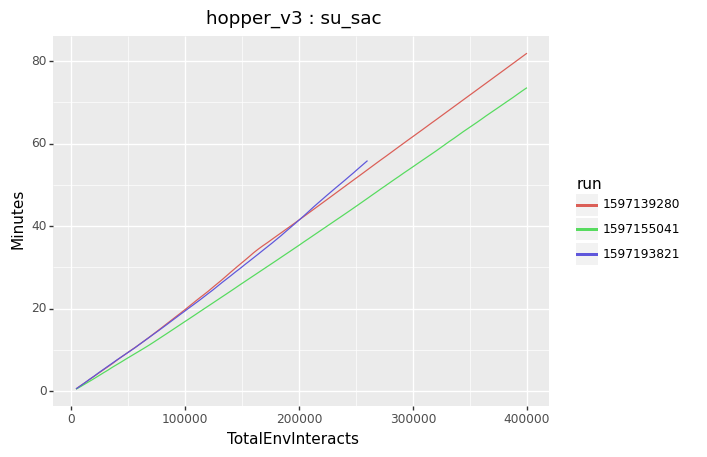

<ggplot: (8762438415024)>

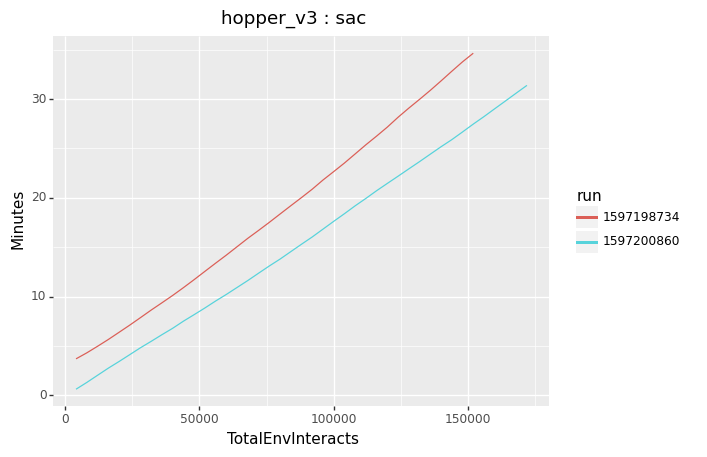

<ggplot: (8762438415024)>

In [419]:
task = 'hopper_v3'
for method in full_data[task].keys():
    display(plot_run_returns(full_data[task][method], col='Minutes', task=task, method=method))
# display(plot_run_returns(full_data[task]['td3']))

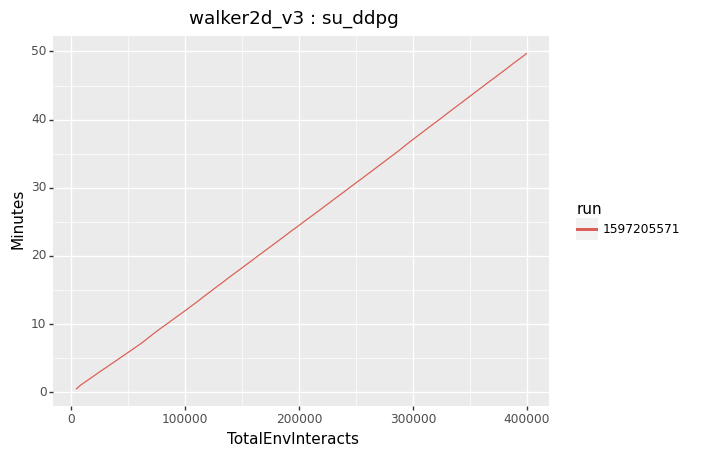

<ggplot: (-9223363274508538841)>

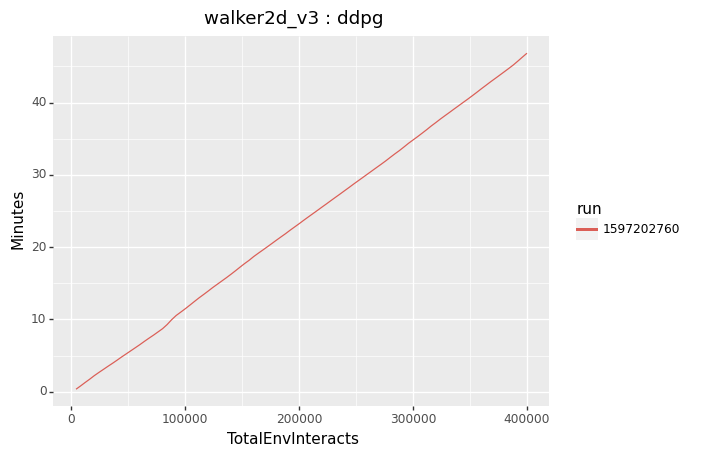

<ggplot: (-9223363274575933552)>

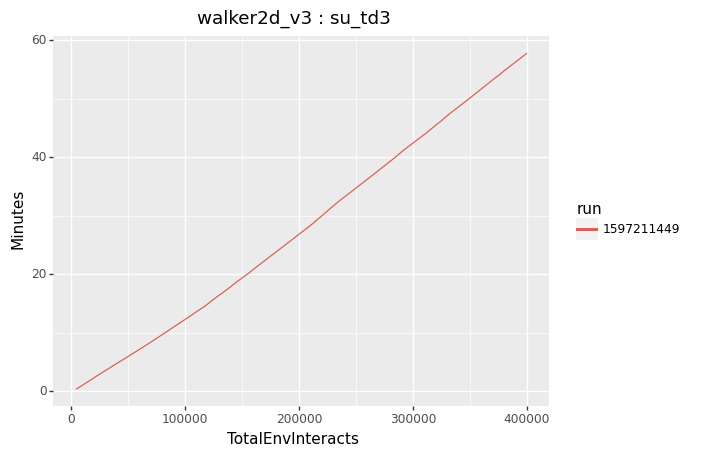

<ggplot: (-9223363274575933552)>

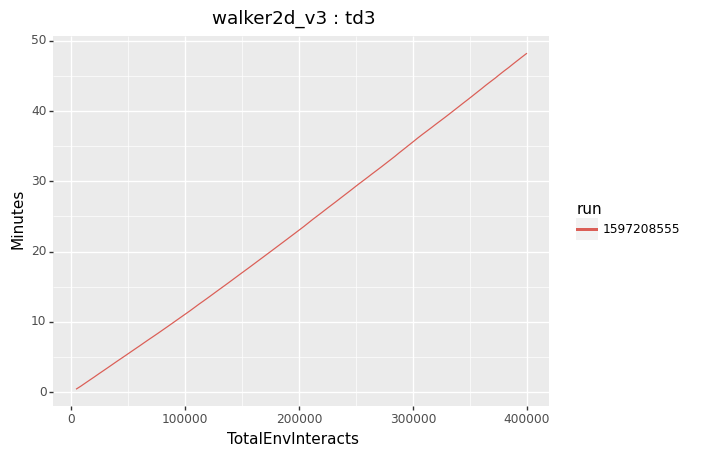

<ggplot: (-9223363274575933552)>

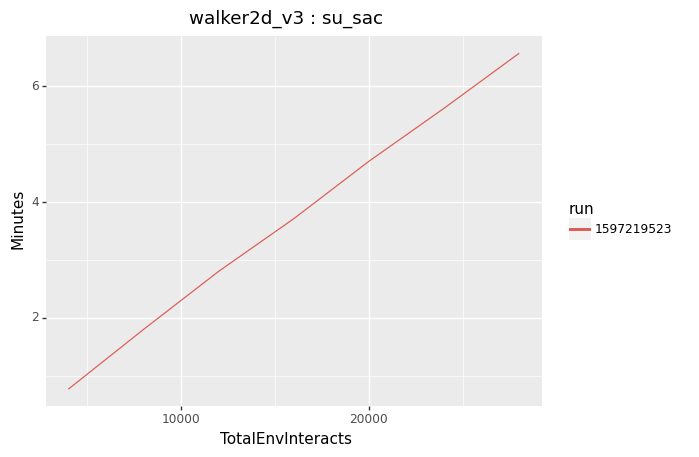

<ggplot: (-9223363274575933552)>

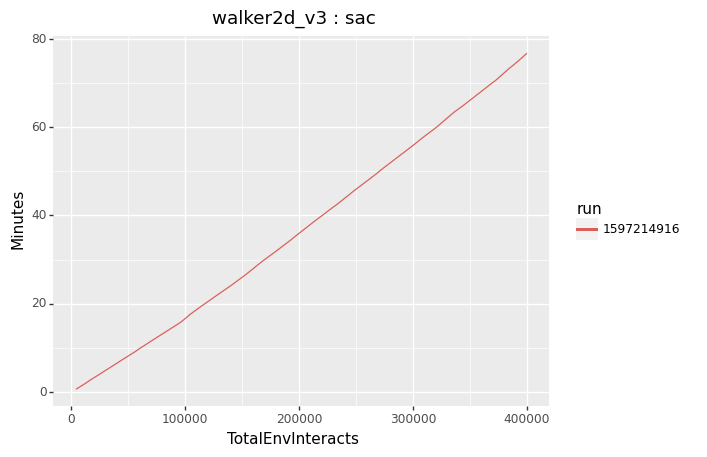

<ggplot: (-9223363274575933552)>

In [420]:
task = 'walker2d_v3'
for method in full_data[task].keys():
    display(plot_run_returns(full_data[task][method], col='Minutes', task=task, method=method))
# display(plot_run_returns(full_data[task]['td3']))